In [62]:
import math
import numpy as np
import pandas as pd

#import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


In [63]:
df = pd.read_csv("C:/Users/Nikitha/Documents/thesis/NITPML01/NITPML01/DATASET/fer2013.csv")

print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [64]:
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [65]:
df['pixels'] = df['pixels'].apply(lambda x: string2array(x))

In [66]:
df.head()

,emotion,pixels,Usage
0,0,"[[[70.0], [80.0], [82.0], [72.0], [58.0], [58....",Training
1,0,"[[[151.0], [150.0], [147.0], [155.0], [148.0],...",Training
2,2,"[[[231.0], [212.0], [156.0], [164.0], [174.0],...",Training
3,4,"[[[24.0], [32.0], [36.0], [30.0], [32.0], [23....",Training
4,6,"[[[4.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Training


In [67]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [68]:
label_to_text = {0:'hot', 1:'bitter', 2:'bland', 3:'sweet', 4: 'salty', 5: 'spicy', 6: 'savoury'}

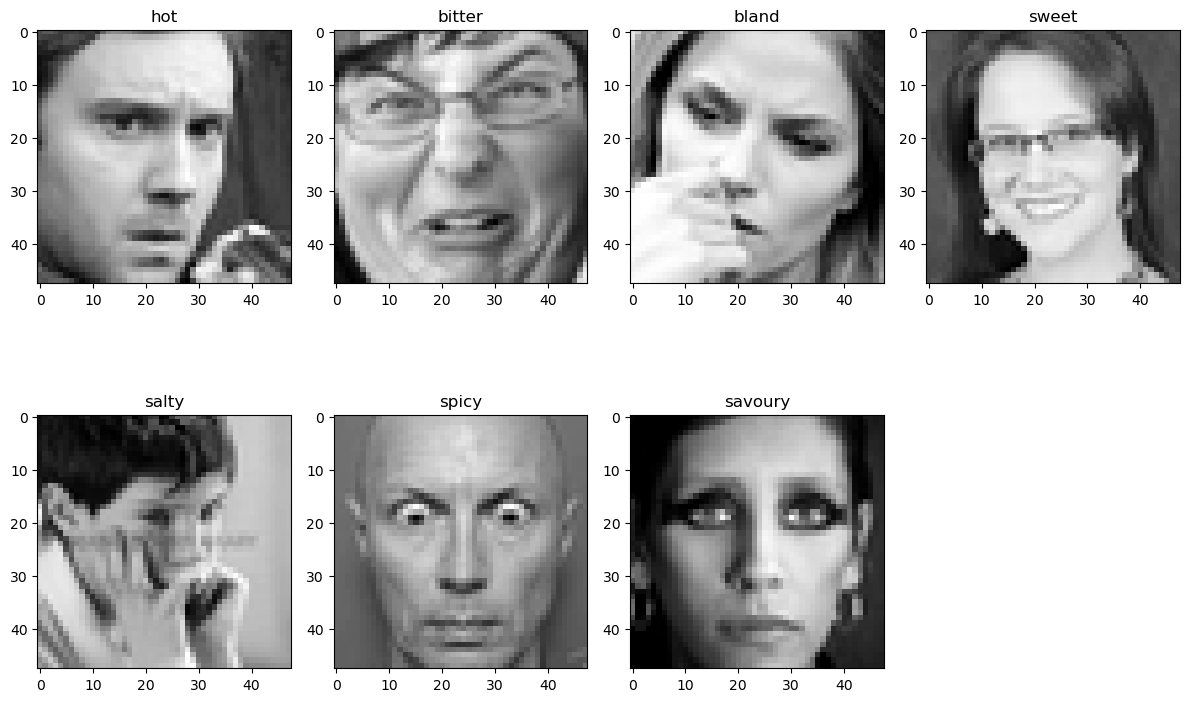

In [69]:
num_rows = 2
num_cols = 4

fig, axes = pyplot.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()

emotions = [0, 1, 2, 3, 4, 5, 6]

for i in emotions:
    data = df[df['emotion'] == i][:1]
    img = data['pixels'].item()
    img = img.reshape(48, 48) 
    ax = axes[i]
    ax.set_title(label_to_text[i])
    ax.imshow(img, cmap='gray')

for i in range(len(emotions), num_rows * num_cols):
    fig.delaxes(axes[i])

pyplot.tight_layout()

pyplot.show()

In [70]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='emotion', ylabel='count'>

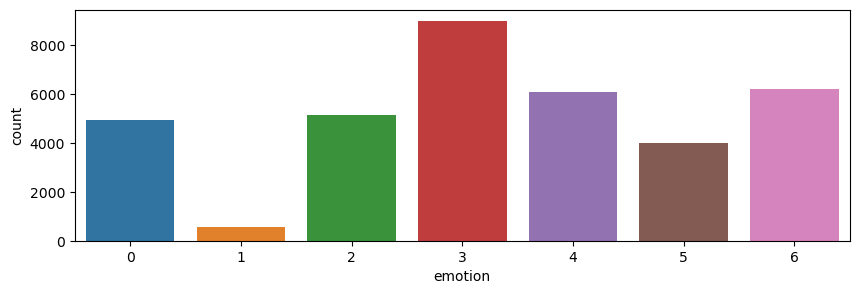

In [71]:
pyplot.figure(figsize = (10,3))
sns.barplot(x = df.emotion.value_counts().index, y = df.emotion.value_counts())

In [72]:
# Separate data based on 'Usage' column
train_data = df[df['Usage'] == 'Training']
test_data = df[df['Usage'] == 'PublicTest']
val_data = df[df['Usage'] == 'PrivateTest']

#Training Data
X_train = train_data['pixels']
y_train = train_data['emotion']

#Testing Data
X_test = test_data['pixels']
y_test = test_data['emotion']

#Validation Data
X_val = val_data['pixels']
y_val = val_data['emotion'] 

In [73]:
X_train = train_data['pixels']
y_train = to_categorical(train_data['emotion'])

X_test = test_data['pixels']
y_test = to_categorical(test_data['emotion'])

X_val = val_data['pixels']
y_val = to_categorical(val_data['emotion'])

In [74]:
X_train = np.stack(X_train, axis = 0)
X_train = X_train.reshape(28709 , 48, 48, 1)

X_test = np.stack(X_test, axis = 0)
X_test = X_test.reshape(3589 , 48, 48, 1)

X_val = np.stack(X_val, axis = 0)
X_val = X_val.reshape(3589 , 48, 48, 1)

In [75]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(28709, 48, 48, 1) (28709, 7)
(3589, 48, 48, 1) (3589, 7)
(3589, 48, 48, 1) (3589, 7)


In [76]:

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_test/255

In [77]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

In [78]:
# BUILD DEEP RESIDUAL NEURAL NETWORK FOR FACIAL POINTS DETECTION MODEL
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)
  # stride equal to 1 , that means they're going to be shifting and scanning only by one pixel
  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [79]:

import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [80]:
input_shape = (48, 48, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# Average Pooling
X = AveragePooling2D((2, 2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(7, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 54, 54, 1)   0           ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 64)   3200        ['zero_padding2d_6[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1[0][0]']           

                                                                                                  
 bn_2_identity_2_b (BatchNormal  (None, 5, 5, 64)    256         ['res_2_identity_2_b[0][0]']     
 ization)                                                                                         
                                                                                                  
 activation_31 (Activation)     (None, 5, 5, 64)     0           ['bn_2_identity_2_b[0][0]']      
                                                                                                  
 res_2_identity_2_c (Conv2D)    (None, 5, 5, 256)    16640       ['activation_31[0][0]']          
                                                                                                  
 bn_2_identity_2_c (BatchNormal  (None, 5, 5, 256)   1024        ['res_2_identity_2_c[0][0]']     
 ization)                                                                                         
          

                                                                                                  
 bn_3_identity_2_b (BatchNormal  (None, 2, 2, 128)   512         ['res_3_identity_2_b[0][0]']     
 ization)                                                                                         
                                                                                                  
 activation_40 (Activation)     (None, 2, 2, 128)    0           ['bn_3_identity_2_b[0][0]']      
                                                                                                  
 res_3_identity_2_c (Conv2D)    (None, 2, 2, 512)    66048       ['activation_40[0][0]']          
                                                                                                  
 bn_3_identity_2_c (BatchNormal  (None, 2, 2, 512)   2048        ['res_3_identity_2_c[0][0]']     
 ization)                                                                                         
          

In [81]:
# train the network
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [82]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5", verbose = 1, save_best_only=True)

In [83]:
history = model_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 100, callbacks=[checkpointer, earlystopping])


Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 1.8379 - accuracy: 0.2931
Epoch 1: val_loss improved from inf to 1.76093, saving model to Emotion_weights.hdf5
448/448 [==============================] - 89s 183ms/step - loss: 1.8379 - accuracy: 0.2931 - val_loss: 1.7609 - val_accuracy: 0.3137
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 1.6164 - accuracy: 0.3843
Epoch 2: val_loss did not improve from 1.76093
448/448 [==============================] - 138s 308ms/step - loss: 1.6164 - accuracy: 0.3843 - val_loss: 1.8427 - val_accuracy: 0.2530
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 1.4939 - accuracy: 0.4282
Epoch 3: val_loss improved from 1.76093 to 1.73918, saving model to Emotion_weights.hdf5
448/448 [==============================] - 140s 312ms/step - loss: 1.4939 - accuracy: 0.4282 - val_loss: 1.7392 - val_accuracy: 0.3739
Epoch 4/100
448/448 [==============================] - ETA: 0s - loss: 1.4050 - accu

448/448 [==============================] - 112s 250ms/step - loss: 0.9713 - accuracy: 0.6337 - val_loss: 1.1974 - val_accuracy: 0.5542
Epoch 33/100
448/448 [==============================] - ETA: 0s - loss: 0.9679 - accuracy: 0.6353
Epoch 33: val_loss did not improve from 1.12018
448/448 [==============================] - 73s 164ms/step - loss: 0.9679 - accuracy: 0.6353 - val_loss: 1.2060 - val_accuracy: 0.5692
Epoch 34/100
448/448 [==============================] - ETA: 0s - loss: 0.9543 - accuracy: 0.6406
Epoch 34: val_loss improved from 1.12018 to 1.09221, saving model to Emotion_weights.hdf5
448/448 [==============================] - 110s 245ms/step - loss: 0.9543 - accuracy: 0.6406 - val_loss: 1.0922 - val_accuracy: 0.5954
Epoch 35/100
448/448 [==============================] - ETA: 0s - loss: 0.9458 - accuracy: 0.6438
Epoch 35: val_loss did not improve from 1.09221
448/448 [==============================] - 63s 140ms/step - loss: 0.9458 - accuracy: 0.6438 - val_loss: 1.2514 - val

KeyboardInterrupt: 

In [84]:
# saving the model architecture to json file

model_json = model_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

In [85]:
score = model_emotion.evaluate(X_Test, y_test)
print('Test Accuracy: {}'.format(score[1]))

113/113 [==============================] - 2s 13ms/step - loss: 1.1329 - accuracy: 0.6074
Test Accuracy: 0.6074115633964539


In [86]:
predicted_classes = np.argmax(model_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

113/113 [==============================] - 2s 14ms/step


<Axes: >

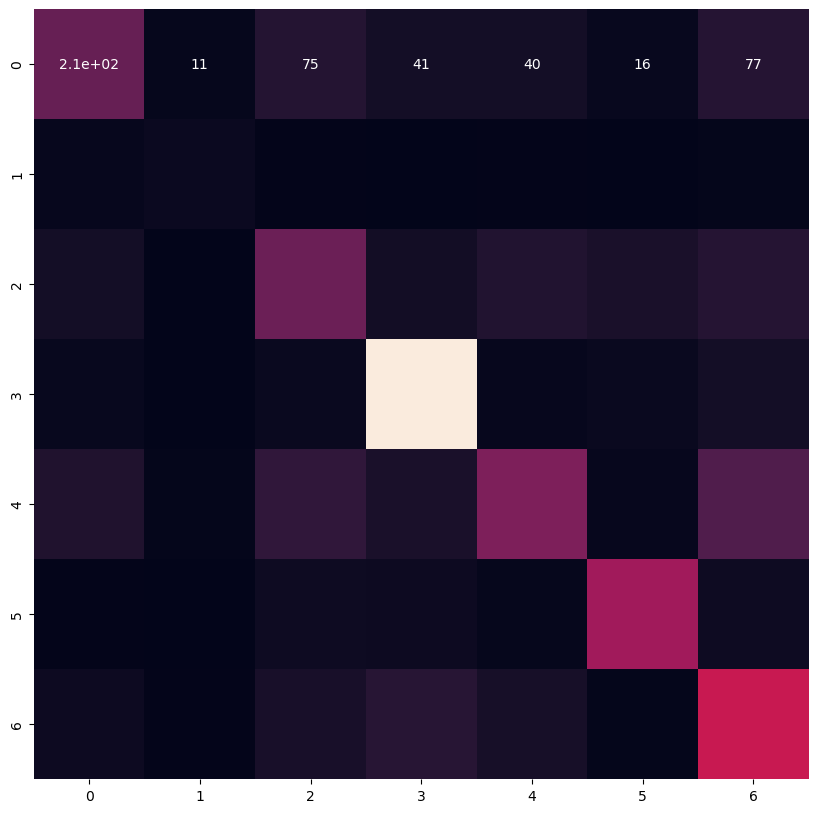

In [87]:
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

In [88]:
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.55      0.44      0.49       467
           1       0.49      0.43      0.46        56
           2       0.44      0.44      0.44       496
           3       0.76      0.87      0.82       895
           4       0.57      0.38      0.46       653
           5       0.74      0.75      0.75       415
           6       0.49      0.64      0.56       607

    accuracy                           0.61      3589
   macro avg       0.58      0.57      0.57      3589
weighted avg       0.60      0.61      0.60      3589



In [89]:
from sklearn.utils import resample

# Calculate the average class count
average_class_count = df['emotion'].value_counts().mean()

# Separate data for each class
class_data = [df[df['emotion'] == i] for i in range(7)]

# Oversample to balance classes based on average class count
oversampled_data = [resample(class_df, replace=True, n_samples=int(average_class_count), random_state=42) for class_df in class_data]
balanced_data = pd.concat(oversampled_data)

In [90]:
balanced_data.head()

,emotion,pixels,Usage
5947,0,"[[[2.0], [5.0], [31.0], [37.0], [18.0], [42.0]...",Training
27250,0,"[[[76.0], [80.0], [82.0], [104.0], [122.0], [1...",Training
22203,0,"[[[114.0], [113.0], [111.0], [113.0], [127.0],...",Training
3227,0,"[[[131.0], [137.0], [136.0], [134.0], [141.0],...",Training
31947,0,"[[[255.0], [252.0], [255.0], [190.0], [73.0], ...",PublicTest


In [91]:
balanced_data.emotion.value_counts()

emotion
0    5126
1    5126
2    5126
3    5126
4    5126
5    5126
6    5126
Name: count, dtype: int64

C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='emotion', ylabel='count'>

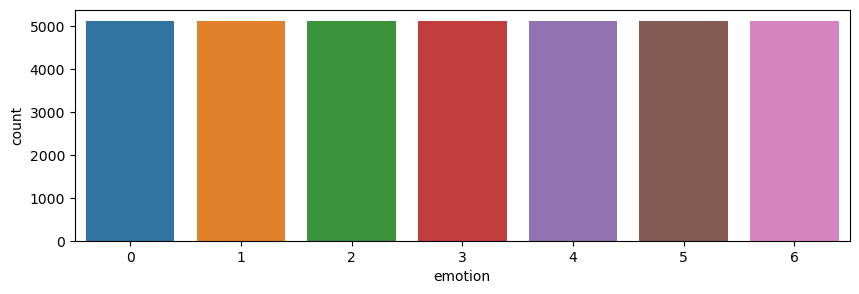

In [92]:
plt.figure(figsize = (10,3))
sns.barplot(x = balanced_data.emotion.value_counts().index, y = balanced_data.emotion.value_counts())

In [93]:
X_train, X_temp, y_train, y_temp = train_test_split(balanced_data['pixels'], balanced_data['emotion'], test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [94]:
print("Train set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Train set size: 28705
Validation set size: 3588
Test set size: 3589


In [95]:
y_train = to_categorical(y_train)

y_test = to_categorical(y_test)

y_val = to_categorical(y_val)

In [96]:
X_train = np.stack(X_train, axis = 0)
X_train = X_train.reshape(28705 , 48, 48, 1)

X_test = np.stack(X_test, axis = 0)
X_test = X_test.reshape(3589 , 48, 48, 1)

X_val = np.stack(X_val, axis = 0)
X_val = X_val.reshape(3588 , 48, 48, 1)

In [97]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(28705, 48, 48, 1) (28705, 7)
(3589, 48, 48, 1) (3589, 7)
(3588, 48, 48, 1) (3588, 7)


In [98]:
X_train = X_train/255
X_val   = X_val /255
X_Test  = X_test/255

In [99]:
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [100]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

checkpointer = ModelCheckpoint(filepath = "EmotionExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [101]:
history = model_emotion.fit(X_train, y_train, batch_size=64,
                            validation_data=(X_val, y_val),
                            steps_per_epoch=len(X_train) // 64,
                            epochs=30,
                            callbacks=[checkpointer, earlystopping])

Epoch 1/30
448/448 [==============================] - ETA: 0s - loss: 0.6365 - accuracy: 0.7751
Epoch 1: val_loss improved from inf to 0.87769, saving model to EmotionExpression_weights.hdf5
448/448 [==============================] - 67s 134ms/step - loss: 0.6365 - accuracy: 0.7751 - val_loss: 0.8777 - val_accuracy: 0.6857
Epoch 2/30
448/448 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8736
Epoch 2: val_loss did not improve from 0.87769
448/448 [==============================] - 109s 243ms/step - loss: 0.3770 - accuracy: 0.8736 - val_loss: 1.0264 - val_accuracy: 0.6606
Epoch 3/30
448/448 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.9225
Epoch 3: val_loss did not improve from 0.87769
448/448 [==============================] - 110s 246ms/step - loss: 0.2386 - accuracy: 0.9225 - val_loss: 0.9752 - val_accuracy: 0.7225
Epoch 4/30
448/448 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.9497
Epoch 4: val_loss did n

In [102]:
model_json = model_emotion.to_json()
with open("FacialExpression-balanced-model.json","w") as json_file:
  json_file.write(model_json)

In [103]:
score = model_emotion.evaluate(X_Test, y_test)
print('Test Accuracy: {}'.format(score[1]))

113/113 [==============================] - 2s 15ms/step - loss: 0.9761 - accuracy: 0.8100
Test Accuracy: 0.8099749088287354


In [104]:
predicted_classes = np.argmax(model_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

113/113 [==============================] - 2s 13ms/step


<Axes: >

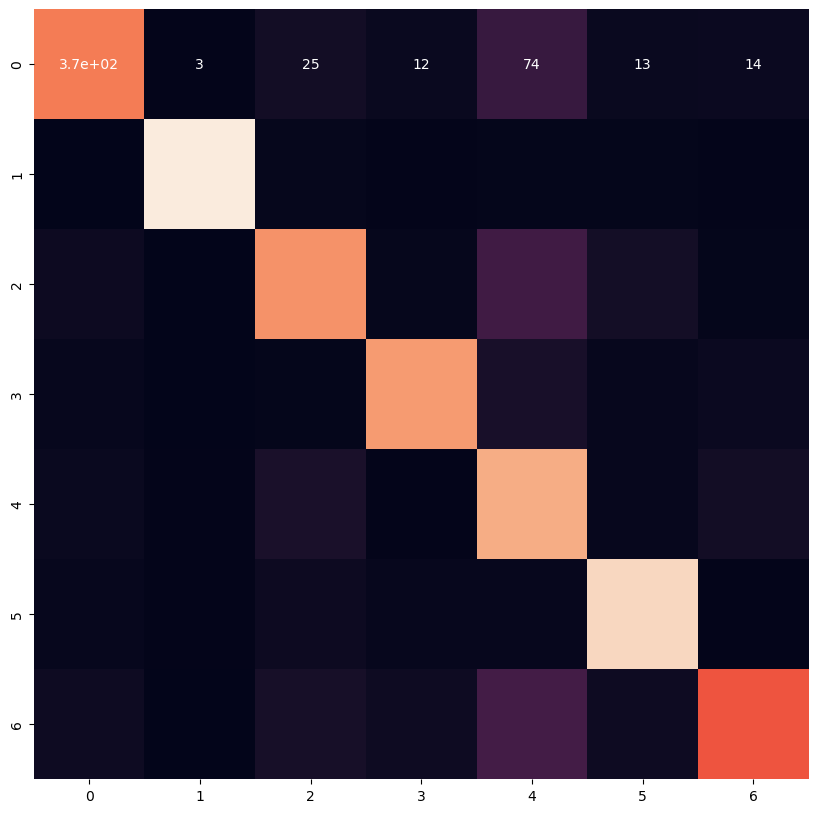

In [105]:
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

In [106]:
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       510
           1       0.98      0.96      0.97       527
           2       0.77      0.74      0.75       535
           3       0.89      0.85      0.87       472
           4       0.59      0.83      0.69       513
           5       0.86      0.91      0.89       527
           6       0.84      0.65      0.73       505

    accuracy                           0.81      3589
   macro avg       0.83      0.81      0.81      3589
weighted avg       0.82      0.81      0.81      3589

